# Setting up<a href="#Setting-up" class="anchor-link">¶</a>

In \[16\]:

    pip install rpy2

    Requirement already satisfied: rpy2 in /home/jupyter/.local/lib/python3.7/site-packages (3.5.0)
    Requirement already satisfied: jinja2 in /opt/conda/lib/python3.7/site-packages (from rpy2) (3.0.3)
    Requirement already satisfied: cffi>=1.10.0 in /opt/conda/lib/python3.7/site-packages (from rpy2) (1.15.0)
    Requirement already satisfied: tzlocal in /home/jupyter/.local/lib/python3.7/site-packages (from rpy2) (4.2)
    Requirement already satisfied: typing-extensions in /opt/conda/lib/python3.7/site-packages (from rpy2) (4.0.1)
    Requirement already satisfied: pytz in /opt/conda/lib/python3.7/site-packages (from rpy2) (2021.3)
    Requirement already satisfied: pycparser in /opt/conda/lib/python3.7/site-packages (from cffi>=1.10.0->rpy2) (2.21)
    Requirement already satisfied: MarkupSafe>=2.0 in /opt/conda/lib/python3.7/site-packages (from jinja2->rpy2) (2.0.1)
    Requirement already satisfied: backports.zoneinfo in /home/jupyter/.local/lib/python3.7/site-packages (from tzlocal->rpy2) (0.2.1)
    Requirement already satisfied: pytz-deprecation-shim in /home/jupyter/.local/lib/python3.7/site-packages (from tzlocal->rpy2) (0.1.0.post0)
    Requirement already satisfied: tzdata in /home/jupyter/.local/lib/python3.7/site-packages (from pytz-deprecation-shim->tzlocal->rpy2) (2022.1)
    Note: you may need to restart the kernel to use updated packages.

In \[14\]:

    pip install --upgrade pip

    Requirement already satisfied: pip in /home/jupyter/.local/lib/python3.7/site-packages (22.0.4)
    Note: you may need to restart the kernel to use updated packages.

In \[1\]:

    #Set up libraries

    # Use the os package to interact with the environment
    import os

    # Bring in Pandas for Dataframe functionality
    import pandas as pd

    # numpy for basics
    import numpy as np

    import sys
    import subprocess
    import glob
    from functools import partial 
    from os import chdir
    import io
    import time
    import matplotlib.pyplot as plt
    import seaborn as sns


    # Use StringIO for working with file contents
    from io import StringIO

    # Enable IPython to display matplotlib graphs
    import matplotlib.pyplot as plt
    %matplotlib inline

    # Enable interaction with the FireCloud API
    from firecloud import api as fapi

    # Import the iPython HTML rendering for displaying links to Google Cloud Console
    from IPython.core.display import display, HTML

    # Import urllib modules for building URLs to Google Cloud Console
    import urllib.parse

    # BigQuery for querying data
    from google.cloud import bigquery

    # Installing and importing rpy2 
    import rpy2.rinterface

In \[2\]:

    %load_ext rpy2.ipython

In \[3\]:

    #Setting paths

    BILLING_PROJECT_ID = os.environ['GOOGLE_PROJECT']
    WORKSPACE_NAMESPACE = os.environ['WORKSPACE_NAMESPACE']
    WORKSPACE_NAME = os.environ['WORKSPACE_NAME']
    WORKSPACE_BUCKET = os.environ['WORKSPACE_BUCKET']

    WORKSPACE_ATTRIBUTES = fapi.get_workspace(WORKSPACE_NAMESPACE, WORKSPACE_NAME).json().get('workspace',{}).get('attributes',{})

    GS_RELEASE_PATH = 'gs://amp-pd-data/releases/2021_v2-5release_0510'
    GS_CLINICAL_RELEASE_PATH = f'{GS_RELEASE_PATH}/clinical/'
    GS_MUTATION_RELEASE_PATH = 'gs://amp-pd-data-tier2/releases/2021_v2-5release_0510'

    GS_WGS_RELEASE_PATH = 'gs://amp-pd-genomics/releases/2021_v2-5release_0510/wgs'
    GS_WGS_RELEASE_PLINK_PATH = os.path.join(GS_WGS_RELEASE_PATH, 'plink')
    GS_WGS_RELEASE_GATK_PATH = os.path.join(GS_WGS_RELEASE_PATH, 'gatk')


    BQ_RELEASE_DATASET = 'amp-pd-research.2021_v2-5release_0510'


    print(BILLING_PROJECT_ID)
    print(GS_CLINICAL_RELEASE_PATH)
    print(GS_WGS_RELEASE_PLINK_PATH)
    print(GS_WGS_RELEASE_GATK_PATH)

    lw-ucl-hrm-test
    gs://amp-pd-data/releases/2021_v2-5release_0510/clinical/
    gs://amp-pd-genomics/releases/2021_v2-5release_0510/wgs/plink
    gs://amp-pd-genomics/releases/2021_v2-5release_0510/wgs/gatk

In \[4\]:

    # # Utility routine for printing a shell command before executing it
    def shell_do(command):
        print(f'Executing: {command}')
        !$command

    def shell_return(command):
        print(f'Executing: {command}', file=sys.stderr)
        output = !$command
        return '\n'.join(output)


    # Utility routine for display a message and a link
    def display_html_link(description, link_text, url):
        html = f'''
        <p>
        </p>
        <p>
        {description}
        <a target=_blank href="{url}">{link_text}</a>.
        </p>
        '''

        display(HTML(html))
        
    # Utility routines for reading files from Google Cloud Storage
    def gcs_read_file(path):
        """Return the contents of a file in GCS"""
        contents = !gsutil -u {BILLING_PROJECT_ID} cat {path}
        return '\n'.join(contents)
        
    def gcs_read_csv(path, sep=None):
        """Return a DataFrame from the contents of a delimited file in GCS"""
        return pd.read_csv(StringIO(gcs_read_file(path)), sep=sep, engine='python')

    # Utility routine for displaying a message and link to Cloud Console
    def link_to_cloud_console_gcs(description, link_text, gcs_path):
        url = '{}?{}'.format(
            os.path.join('https://console.cloud.google.com/storage/browser',
                         gcs_path.replace("gs://","")),
            urllib.parse.urlencode({'userProject': BILLING_PROJECT_ID}))

        display_html_link(description, link_text, url)
        
    # Get the data from a query
    def bq_query(query):
        print(f'Executing: {query}', file=sys.stderr)
        return pd.read_gbq(query, project_id=BILLING_PROJECT_ID, dialect='standard')

    # Utility routine for displaying a message and link to Cloud Console
    def link_to_cloud_console_gcs(description, link_text, gcs_path):
        url = '{}?{}'.format(
            os.path.join('https://console.cloud.google.com/storage/browser',
                         gcs_path.replace("gs://","")),
            urllib.parse.urlencode({'userProject': BILLING_PROJECT_ID}))

        display_html_link(description, link_text, url)
        
    # Utility routine for displaying a message and link to Cloud Console
    def link_to_cloud_console_bq(description, link_text, bq_dataset, bq_table=None):
        project, dataset = bq_dataset.split('.', 1)
        if bq_table:
            page_params = {'page': 'table', 'p': project, 'd': dataset, 't': bq_table}
        else:
            page_params = {'page': 'dataset', 'p': project, 'd': dataset}
        
        url = '{}?{}'.format(
            'https://console.cloud.google.com/bigquery',
            urllib.parse.urlencode(page_params))

        display_html_link(description, link_text, url)    

    # Utility routine for printing a query before executing it
    def bq_query(query):
        """Return the contents of a query against BigQuery"""
        return pd.read_gbq(
            query,
            project_id=BILLING_PROJECT_ID,
            dialect='standard')

In \[6\]:

    %%R
    if (!require(tidyverse)) install.packages('tidyr')
    if (!require(data.table)) install.packages('data.table')
    if (!require(dplyr)) install.packages('dplyr')
    if (!require(plyr)) install.packages('plyr')
    if (!require(ggplot2)) install.packages('ggplot2')
    if (!require(caret)) install.packages('caret')


    # Load the necessary packages 
    library(tidyr)
    library(data.table)
    library(dplyr)
    library(plyr)
    library(ggplot2)
    library(caret)

# Preparing clinical files<a href="#Preparing-clinical-files" class="anchor-link">¶</a>

In \[7\]:

    # Importing everyone with clinical data
    demographics_df = gcs_read_csv(os.path.join(GS_CLINICAL_RELEASE_PATH, 'Demographics.csv'))
    demographics_df.rename(columns = {'participant_id':'ID'}, inplace = True)
    demographics_df.info()

    <class 'pandas.core.frame.DataFrame'>
    RangeIndex: 11226 entries, 0 to 11225
    Data columns (total 9 columns):
     #   Column                 Non-Null Count  Dtype 
    ---  ------                 --------------  ----- 
     0   ID                     11226 non-null  object
     1   GUID                   3603 non-null   object
     2   visit_name             11226 non-null  object
     3   visit_month            11226 non-null  int64 
     4   age_at_baseline        11226 non-null  int64 
     5   sex                    11226 non-null  object
     6   ethnicity              6621 non-null   object
     7   race                   11207 non-null  object
     8   education_level_years  6640 non-null   object
    dtypes: int64(2), object(7)
    memory usage: 789.5+ KB

In \[8\]:

    # Recoding sex
    conditions = [
         (demographics_df['sex'] == "Male"),
         (demographics_df['sex'] == "Female")]
    choices = [1,2]

    demographics_df['SEX'] = np.select(conditions, choices, default=None).astype(np.int64)
    demographics_df.info()

    <class 'pandas.core.frame.DataFrame'>
    RangeIndex: 11226 entries, 0 to 11225
    Data columns (total 10 columns):
     #   Column                 Non-Null Count  Dtype 
    ---  ------                 --------------  ----- 
     0   ID                     11226 non-null  object
     1   GUID                   3603 non-null   object
     2   visit_name             11226 non-null  object
     3   visit_month            11226 non-null  int64 
     4   age_at_baseline        11226 non-null  int64 
     5   sex                    11226 non-null  object
     6   ethnicity              6621 non-null   object
     7   race                   11207 non-null  object
     8   education_level_years  6640 non-null   object
     9   SEX                    11226 non-null  int64 
    dtypes: int64(3), object(7)
    memory usage: 877.2+ KB

In \[9\]:

    # Clean up and drop the columns we don't need anymore 
    demographics_baseline_clean_df = demographics_df.drop(columns=['GUID',
                                                                   'ethnicity',
                                                                   'sex',
                                                                   'race',
                                                                   'age_at_baseline',
                                                                   'education_level_years',
                                                                   'visit_month',
                                                                   'visit_name']).copy()

    demographics_baseline_clean_df.info()

    <class 'pandas.core.frame.DataFrame'>
    RangeIndex: 11226 entries, 0 to 11225
    Data columns (total 2 columns):
     #   Column  Non-Null Count  Dtype 
    ---  ------  --------------  ----- 
     0   ID      11226 non-null  object
     1   SEX     11226 non-null  int64 
    dtypes: int64(1), object(1)
    memory usage: 175.5+ KB

In \[10\]:

    # Identify mutation carriers
    mutation_df = gcs_read_csv(os.path.join(GS_MUTATION_RELEASE_PATH, 'amp_pd_participant_mutations.csv'))
    mutation_df.info()

    <class 'pandas.core.frame.DataFrame'>
    RangeIndex: 10418 entries, 0 to 10417
    Data columns (total 5 columns):
     #   Column                           Non-Null Count  Dtype 
    ---  ------                           --------------  ----- 
     0   participant_id                   10418 non-null  object
     1   has_known_GBA_mutation_in_WGS    10418 non-null  object
     2   has_known_LRRK2_mutation_in_WGS  10418 non-null  object
     3   has_known_SNCA_mutation_in_WGS   10418 non-null  object
     4   has_known_PD_mutation_in_WGS     10418 non-null  object
    dtypes: object(5)
    memory usage: 407.1+ KB

In \[11\]:

    # Identify LRRK2 carriers
    mutation_lrrk2_df = mutation_df[(mutation_df.has_known_LRRK2_mutation_in_WGS == "Yes")]
    mutation_lrrk2_df.info()

    <class 'pandas.core.frame.DataFrame'>
    Int64Index: 918 entries, 73 to 10417
    Data columns (total 5 columns):
     #   Column                           Non-Null Count  Dtype 
    ---  ------                           --------------  ----- 
     0   participant_id                   918 non-null    object
     1   has_known_GBA_mutation_in_WGS    918 non-null    object
     2   has_known_LRRK2_mutation_in_WGS  918 non-null    object
     3   has_known_SNCA_mutation_in_WGS   918 non-null    object
     4   has_known_PD_mutation_in_WGS     918 non-null    object
    dtypes: object(5)
    memory usage: 43.0+ KB

In \[12\]:

    # Renaming columns
    mutation_lrrk2_df = mutation_lrrk2_df[['participant_id']].copy()
    mutation_lrrk2_df.columns = ['ID']
    mutation_lrrk2_df['FID'] = mutation_lrrk2_df['ID']

    mutation_lrrk2_df.info()

    <class 'pandas.core.frame.DataFrame'>
    Int64Index: 918 entries, 73 to 10417
    Data columns (total 2 columns):
     #   Column  Non-Null Count  Dtype 
    ---  ------  --------------  ----- 
     0   ID      918 non-null    object
     1   FID     918 non-null    object
    dtypes: object(2)
    memory usage: 21.5+ KB

In \[13\]:

    pd_case_control_df = gcs_read_csv(os.path.join(GS_RELEASE_PATH, 'amp_pd_case_control.csv'))
    pd_case_control_df.info()

    <class 'pandas.core.frame.DataFrame'>
    RangeIndex: 10772 entries, 0 to 10771
    Data columns (total 5 columns):
     #   Column                          Non-Null Count  Dtype 
    ---  ------                          --------------  ----- 
     0   participant_id                  10772 non-null  object
     1   diagnosis_at_baseline           10772 non-null  object
     2   diagnosis_latest                10772 non-null  object
     3   case_control_other_at_baseline  10772 non-null  object
     4   case_control_other_latest       10772 non-null  object
    dtypes: object(5)
    memory usage: 420.9+ KB

In \[14\]:

    # Subset baseline and latest diagnosis 
    pd_case_control_diagnosis_df = pd_case_control_df[['participant_id','diagnosis_latest']].copy()
    pd_case_control_diagnosis_df.columns = ['ID', 'LATEST_DIAGNOSIS']
    pd_case_control_diagnosis_df.info()
    #Total of 10 772 people

    pd_case_control_diagnosis_df['LATEST_DIAGNOSIS'].value_counts()

    <class 'pandas.core.frame.DataFrame'>
    RangeIndex: 10772 entries, 0 to 10771
    Data columns (total 2 columns):
     #   Column            Non-Null Count  Dtype 
    ---  ------            --------------  ----- 
     0   ID                10772 non-null  object
     1   LATEST_DIAGNOSIS  10772 non-null  object
    dtypes: object(2)
    memory usage: 168.4+ KB

Out\[14\]:

    No PD Nor Other Neurological Disorder        4312
    LBD                                          2614
    Parkinson's Disease                          2392
    Idiopathic PD                                1135
    Multiple System Atrophy                        71
    Progressive Supranuclear Palsy                 61
    Essential Tremor                               47
    Prodromal non-motor PD                         36
    Prodromal motor PD                             36
    Other Neurological Disorder(s)                 30
    Dementia With Lewy Bodies                      14
    Corticobasal Degeneration                       8
    Neuroleptic-Induced Parkinsonism                3
    Parkinsonism                                    3
    Possible Alzheimer's Disease                    3
    Vascular Parkinsonism                           2
    Fahr's Syndrome                                 1
    Alzheimer's Disease                             1
    Psychogenic Illness                             1
    Juvenile Autosomal Recessive Parkinsonism       1
    Olivopontocerebellar Atrophy                    1
    Name: LATEST_DIAGNOSIS, dtype: int64

In \[15\]:

    # Identify PD
    PD_df = pd_case_control_diagnosis_df[(pd_case_control_diagnosis_df.LATEST_DIAGNOSIS == "Parkinson's Disease") | (pd_case_control_diagnosis_df.LATEST_DIAGNOSIS == "Idiopathic PD")].copy()
    PD_df.info()

    <class 'pandas.core.frame.DataFrame'>
    Int64Index: 3527 entries, 2801 to 6327
    Data columns (total 2 columns):
     #   Column            Non-Null Count  Dtype 
    ---  ------            --------------  ----- 
     0   ID                3527 non-null   object
     1   LATEST_DIAGNOSIS  3527 non-null   object
    dtypes: object(2)
    memory usage: 82.7+ KB

In \[16\]:

    # Identify controls
    Control_df = pd_case_control_diagnosis_df[(pd_case_control_diagnosis_df.LATEST_DIAGNOSIS == "No PD Nor Other Neurological Disorder")].copy()
    Control_df.info()

    <class 'pandas.core.frame.DataFrame'>
    Int64Index: 4312 entries, 6460 to 10771
    Data columns (total 2 columns):
     #   Column            Non-Null Count  Dtype 
    ---  ------            --------------  ----- 
     0   ID                4312 non-null   object
     1   LATEST_DIAGNOSIS  4312 non-null   object
    dtypes: object(2)
    memory usage: 101.1+ KB

In \[17\]:

    %%R -i mutation_lrrk2_df

    LRRK2 <- mutation_lrrk2_df

    summary(LRRK2)

          ID                FID           
     Length:918         Length:918        
     Class :character   Class :character  
     Mode  :character   Mode  :character  

In \[18\]:

    %%R -i PD_df 

    # PD with LRRK2 mutation
    PD <- PD_df

    LRRK2_PD <- inner_join(PD_df, LRRK2, by = "ID") %>%
    mutate(DIAGNOSIS = "LRRK2_PD", ID = FID) %>%
    dplyr::rename(IID = ID) %>%
    select(FID, IID, DIAGNOSIS) %>%
    distinct(FID, .keep_all = TRUE)

    summary(LRRK2_PD)

         FID                IID             DIAGNOSIS        
     Length:466         Length:466         Length:466        
     Class :character   Class :character   Class :character  
     Mode  :character   Mode  :character   Mode  :character  

In \[19\]:

    %%R

    # PD without LRRK2 mutation
    LRRK2_NOPD <- anti_join(LRRK2, PD_df, by = "ID") %>%
    mutate(DIAGNOSIS = "LRRK2_NOPD", ID = FID) %>%
    dplyr::rename(IID = ID) %>%
    select(FID, IID, DIAGNOSIS) %>%
    distinct(FID, .keep_all = TRUE)


    summary(LRRK2_NOPD)

         FID                IID             DIAGNOSIS        
     Length:452         Length:452         Length:452        
     Class :character   Class :character   Class :character  
     Mode  :character   Mode  :character   Mode  :character  

In \[20\]:

    %%R -i Control_df

    # Controls
    Controls <- Control_df

    Controls <- Controls %>%
    mutate(DIAGNOSIS = "CONTROL")%>%
    dplyr::rename(IID = ID) %>%
    mutate(FID = IID) %>%
    select(FID, IID, DIAGNOSIS) %>%
    distinct(FID, .keep_all = TRUE)


    summary(Controls)

         FID                IID             DIAGNOSIS        
     Length:4312        Length:4312        Length:4312       
     Class :character   Class :character   Class :character  
     Mode  :character   Mode  :character   Mode  :character  

In \[25\]:

    %%R 

    CLIN <- full_join(LRRK2_PD, LRRK2_NOPD, by = c("IID", "FID", "DIAGNOSIS"))
    CLIN2 <- full_join(CLIN, Controls, by = c("IID", "FID", "DIAGNOSIS"))

In \[23\]:

    %%R -i demographics_baseline_clean_df

    SEX <- demographics_baseline_clean_df %>%
    dplyr::rename(IID = ID)

In \[26\]:

    %%R
    CLIN3 <- inner_join(CLIN2, SEX, by = "IID") %>%
    mutate(DIAGNOSIS1 = case_when(DIAGNOSIS == "CONTROL" ~ 0,
                                 DIAGNOSIS == "LRRK2_PD" ~ 1,
                                 DIAGNOSIS == "LRRK2_NOPD" ~ 2))

In \[ \]:

    %%R
    ID_KEEP <- CLIN3 %>%
    select(FID, IID)

    write.table(ID_KEEP,"/home/jupyter/notebooks/bin/LRRK2/ID_KEEP.txt", row.names = F, col.names = F, quote = F)

# Genetic QC<a href="#Genetic-QC" class="anchor-link">¶</a>

\#\# Extracting individuals to keep plink --bfile
/home/jupyter/notebooks/bin/genetic_data/AMP --keep ID_KEEP.txt
--make-bed --out LRRK2_CONTROL \#\# QC \#Sample plink --bfile
LRRK2_CONTROL --geno 0.05 --indep-pairwise 50 5 0.05 --maf 0.05 --out
pruning plink --bfile LRRK2_CONTROL --extract pruning.prune.in
--make-bed --out pruned_data plink --bfile pruned_data --het --out
prunedHet awk '{if (\$6 \<= -0.15) print \$0 }' prunedHet.het \>
outliers1.txt awk '{if (\$6 \>= 0.15) print \$0 }' prunedHet.het \>
outliers2.txt cat outliers1.txt outliers2.txt \>
HETEROZYGOSITY_OUTLIERS.txt cut -f 1,2 HETEROZYGOSITY_OUTLIERS.txt \>
all_outliers.txt plink --bfile LRRK2_CONTROL --remove all_outliers.txt
--make-bed --out LRRK2_CONTROL.het plink --bfile LRRK2_CONTROL.het
--mind 0.05 --make-bed --out LRRK2_CONTROL.het.mind \#Variant plink
--bfile LRRK2_CONTROL.het.mind --geno 0.05 --hwe 1e-6 --maf 0.01
--make-bed --out LRRK2_CONTROL.het.mind.geno.maf.hwe \#IBD plink2
--bfile LRRK2_CONTROL.het.geno.maf.hwe --extract pruned.prune.in
--king-table-filter 0.1 --make-king-table --out IBD awk '{print \$1 ,
\$2}' IBD.kin0 \> IBD_remove.txt plink --bfile
LRRK2_CONTROL.het.geno.maf.hwe --make-bed --out
LRRK2_CONTROL.het.geno.maf.hwe.IBD --remove IBD_remove.txt \#Ancestry
plink2 --bfile
/home/jupyter/notebooks/bin/LRRK2/QC/LRRK2_CONTROL.het.geno.maf.hwe.IBD
--make-bed --out cohortPreMerge --rm-dup exclude-all --autosome
--snps-only --mac 2 plink2 --alt1-allele
/home/jupyter/notebooks/bin/genetic_data/ANCESTRY/reference.bim 5 2
--bfile cohortPreMerge --extract
/home/jupyter/notebooks/bin/genetic_data/ANCESTRY/reference.bim
--make-bed --out cohortToMergeHapmap --update-map
/home/jupyter/notebooks/bin/genetic_data/ANCESTRY/reference.bim 4 2
plink --bfile cohortToMergeHapmap --bmerge
/home/jupyter/notebooks/bin/genetic_data/ANCESTRY/reference --out
trymerge plink --bfile trymerge --bmerge
/home/jupyter/notebooks/bin/genetic_data/ANCESTRY/reference --geno 0.05
--hwe 1e-6 --maf 0.01 --make-bed --out cohortAndHapmap plink --bfile
cohortAndHapmap --indep-pairwise 50 5 0.05 --out prune plink --bfile
cohortAndHapmap \\ --extract prune.prune.in \\ --make-bed \\ --out
pruned plink --bfile pruned \\ --out cohortAndHapmap_PCA \\ --pca

In \[11\]:

    ## Make a Scree Plot
    dfpcaVal = pd.read_csv('/home/jupyter/notebooks/bin/LRRK2/ANCESTRY/cohortAndHapmap_PCA.eigenval', header=None)
    dfpcaVal.plot.line()
    plt.title('Scree Plot')
    plt.show()

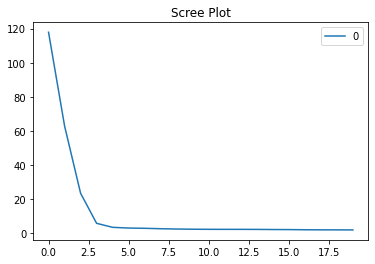

In \[12\]:

    %%R

    # Making a Scree plot

    # Read in the PCA Eigenvalues and Eigenvectors
    print("Read in pca.eigenval files from PLINK")
    eigenval <- read.delim("~/notebooks/bin/LRRK2/ANCESTRY/cohortAndHapmap_PCA.eigenval", sep ="\t", header = F, stringsAsFactors = F)

    # Update column names
    colnames(eigenval)[1] <- "Eigenvalues"
    eigenval$PC <- as.numeric(rownames(eigenval))
    eigenval$VarianceExplained <- eigenval$Eigenvalues/sum(eigenval$Eigenvalues)*100

    # Keeping only the first 10 PCs
    eigenval2 <- head(eigenval,10)

    # Generating the plot
    scree <- ggplot(data = eigenval2, aes(x = PC, y = VarianceExplained)) +
      geom_line() +
      geom_point() +
      theme_bw() +
      theme(panel.grid.minor = element_blank()) +
      scale_x_continuous(name = "Principal Components", breaks = seq(0,10,1), limits = c(NA,10)) +
      scale_y_continuous(name = "Percent (%) Variance Explained", breaks = seq(0,50,5), limits = c(0,50)) +
      ggtitle("Scree Plot") +
      theme(plot.title = element_text(hjust = 0.5, face = "bold"))

    scree

    [1] "Read in pca.eigenval files from PLINK"

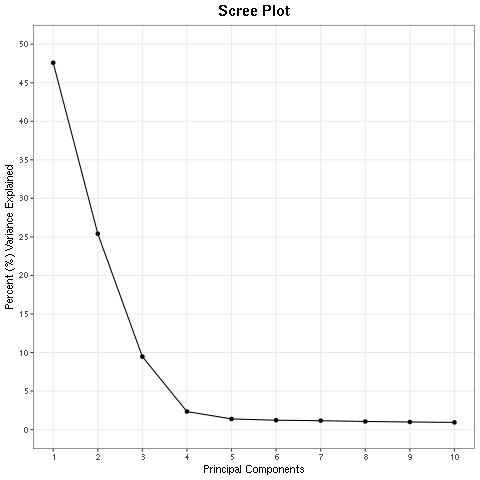

In \[13\]:

    # PC plot
    df = pd.read_csv('~/notebooks/bin/LRRK2/ANCESTRY/cohortAndHapmap_PCA.eigenvec', delim_whitespace=True, header = None)
    df.columns=['FID', 'IID', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20']

    df.info()

    <class 'pandas.core.frame.DataFrame'>
    RangeIndex: 4810 entries, 0 to 4809
    Data columns (total 22 columns):
     #   Column  Non-Null Count  Dtype  
    ---  ------  --------------  -----  
     0   FID     4810 non-null   object 
     1   IID     4810 non-null   object 
     2   PC1     4810 non-null   float64
     3   PC2     4810 non-null   float64
     4   PC3     4810 non-null   float64
     5   PC4     4810 non-null   float64
     6   PC5     4810 non-null   float64
     7   PC6     4810 non-null   float64
     8   PC7     4810 non-null   float64
     9   PC8     4810 non-null   float64
     10  PC9     4810 non-null   float64
     11  PC10    4810 non-null   float64
     12  PC11    4810 non-null   float64
     13  PC12    4810 non-null   float64
     14  PC13    4810 non-null   float64
     15  PC14    4810 non-null   float64
     16  PC15    4810 non-null   float64
     17  PC16    4810 non-null   float64
     18  PC17    4810 non-null   float64
     19  PC18    4810 non-null   float64
     20  PC19    4810 non-null   float64
     21  PC20    4810 non-null   float64
    dtypes: float64(20), object(2)
    memory usage: 826.8+ KB

In \[14\]:

    df[['ID', 'Population', 'Continent']] = df.IID.str.split('_', expand=True)
    df['Population']=df.Population.where(pd.notna(df.Continent), '"STUDY"')
    df.Continent.where(pd.notna(df.Continent), '"STUDY"', inplace=True)
    colors = ['pink','green', 'purple', 'blue']
    fig, ax = plt.subplots(1, 1)
    for i, (j, group) in enumerate(df.groupby('Continent')):
        if j=='"STUDY"':
            ax.scatter(x=group.PC1, y=group.PC2, color=colors[i], label=j, s = 10, alpha = 1)
        else:
            sns.kdeplot(x=group.PC1, y=group.PC2, n_levels=3, ax=ax, label=j, color=colors[i], alpha=0.8)
    plt.title('AMP cohort')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=11)
    plt.show()

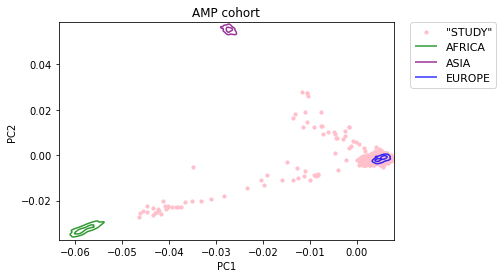

In \[15\]:

    # Infer ancestry
    dfpop = df.pivot_table(index='Continent', values=['PC1', 'PC2'], aggfunc=['mean', 'std'])

    # Get the threshold table of mean +/- 6SD
    def funcThres(x):
        lwl = x['mean'] - 6 * x['std']
        hgl = x['mean'] + 6 * x['std']
        return pd.Series({'lwl':lwl, 'hgl':hgl})
    thres = dfpop.apply(funcThres, axis=1)

    # function to infer ancestry
    def funcInfPop(x):
        if x.Continent != '"STUDY"':
            InfPop = 'REF'
        else:
            InfPop = 'ADMIX'
            for continent in ['EUROPE', 'ASIA', 'AFRICA']:
                if (thres.loc[continent, 'lwl']['PC1'] < x.PC1) & \
                  (x.PC1 < thres.loc[continent, 'hgl']['PC1']) & \
                  (thres.loc[continent, 'lwl']['PC2'] < x.PC2) & \
                  (x.PC2 < thres.loc[continent, 'hgl']['PC2']):
                        InfPop = continent
        return InfPop
    df['InfPop'] = df.apply(funcInfPop, axis=1)

In \[16\]:

    # Europeans
    dfpca_euro = df[(df.Continent=='EUROPE') | (df.InfPop=='EUROPE')]
    colors = ['pink', 'black', 'blue', 'purple', 'orange', 'green', 'red']
    fig, ax = plt.subplots(1, 1)
    for i, (j, group) in enumerate(dfpca_euro.groupby('Population')):
        if j=='"STUDY"':
            ax.scatter(x=group.PC1, y=group.PC2, color=colors[i], label=j, s = 10, alpha = 1)
        else:
            ax.scatter(x=group.PC1, y=group.PC2, color=colors[i], label=j, s = 10, alpha = 1)
    #         sns.kdeplot(x=group.PC1, y=group.PC2, n_levels=3, ax=ax, label=j, color=colors[i], alpha=0.8)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=11)
    plt.show()

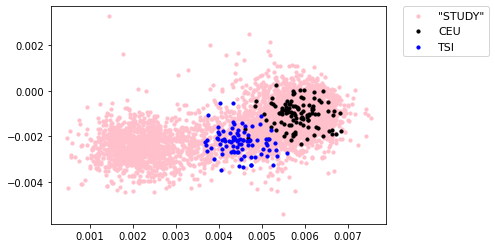

In \[17\]:

    # Europeans 
        # PC3 is the determinant of AJ (refer to the AMP-PD genetic resource paper...)
    fig, ax = plt.subplots(1, 1)
    for i, (j, group) in enumerate(dfpca_euro.groupby('Population')):
        if j=='"STUDY"':
            ax.scatter(x=group.PC1, y=group.PC3, color=colors[i], label=j, s = 10, alpha = 1)
        else:
            ax.scatter(x=group.PC1, y=group.PC3, color=colors[i], label=j, s = 10, alpha = 1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=11)
    plt.show()

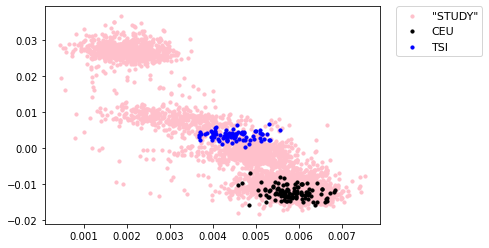

In \[18\]:

    # Create ancestry files
    df.loc[df.InfPop!='REF', ['FID', 'IID', 'InfPop'] + [f'PC{i+1}' for i in range(10)]].to_csv('~/notebooks/bin/genetic_data/ANCESTRY/genetic_ancestry_all_pca.csv', index=False)
    for continent in ['EUROPE', 'ASIA', 'AFRICA', 'ADMIX']:
        t = df.loc[df.InfPop==continent, ['FID', 'IID']]
        print(t.shape)
        t.to_csv(f'~/notebooks/bin/LRRK2/ANCESTRY/{continent}.txt', index=False, sep='\t')

    (4092, 2)
    (0, 2)
    (0, 2)
    (78, 2)

In \[ \]:

    # Keeping only Europeans
    plink --bfile /home/jupyter/notebooks/bin/LRRK2/QC/LRRK2_CONTROL.het.geno.maf.hwe.IBD --keep EUROPE.txt --make-bed --out LRRK_CONTROL_QC

In \[21\]:

    %%R 

    # Removing palindromes

    bim = read.table("~/notebooks/bin/LRRK2/LRRK_CONTROL_QC.bim", header=F)

    #Get indices of A/T and G/C SNPs
    w = which((bim$V5=="A" & bim$V6=="T") |
    (bim$V5=="T" & bim$V6=="A") |
    (bim$V5=="C" & bim$V6=="G") |
    (bim$V5=="G" & bim$V6=="C"))

    #Extract A/T and G/C SNPs
    at.cg.snps = bim[w,]

In \[23\]:

    %%R

    write.table(at.cg.snps$V2,"~/notebooks/bin/LRRK2/at-cg-snps.txt", row.names = F, col.names = F, quote = F)

\# remove duplicate IDs and reformat to fit with base dataset plink
--bfile LRRK_CONTROL_QC.nopalindrome --rm-dup force-first
--set-all-var-ids @:\# --make-bed --out FINAL_FILE \# Calculating GRS
plink --bfile FINAL_FILE --score --out PD_GRS

# Genetic risk score<a href="#Genetic-risk-score" class="anchor-link">¶</a>

In \[121\]:

    %%R

    # Reading in the GRS file 

    PROFILE <- read.table("/home/jupyter/notebooks/bin/LRRK2/PD_GRS.profile", header = T) 
    data <- merge(PROFILE, FINAL_COV, by = c("FID", "IID")) %>%
    distinct(FID, .keep_all=TRUE)

    plyr::count(data$DIAGNOSIS)

               x freq
    1    CONTROL 3435
    2 LRRK2_NOPD  275
    3   LRRK2_PD  382

In \[122\]:

    %%R

    # Standardizing
    meanControls <- mean(data$SCORE[data$DIAGNOSIS1 == 0])
    sdControls <- sd(data$SCORE[data$DIAGNOSIS1 == 0])
    data$zSCORE <- (data$SCORE - meanControls)/sdControls

    head(data)

          FID     IID PHENO CNT CNT2      SCORE DIAGNOSIS SEX DIAGNOSIS1
    1 BF-1001 BF-1001    -9 138   73 -0.0148014   CONTROL   1          0
    2 BF-1005 BF-1005    -9 138   63 -0.0184681   CONTROL   2          0
    3 BF-1009 BF-1009    -9 138   77 -0.0118196   CONTROL   1          0
    4 BF-1012 BF-1012    -9 138   58 -0.0162667   CONTROL   2          0
    5 BF-1013 BF-1013    -9 138   66 -0.0218370   CONTROL   1          0
    6 BF-1014 BF-1014    -9 138   68 -0.0163152   CONTROL   2          0
              PC1         PC2         PC3         PC4         PC5         PC6
    1 -0.01291440 -0.01181660 -0.00545987 -0.02402340  0.01018320 -0.00226602
    2 -0.00957045 -0.00726275  0.01364930  0.08271520 -0.03802810  0.02040960
    3 -0.01278960 -0.01161940 -0.00139427 -0.00735203  0.02450790 -0.02319190
    4  0.02901410 -0.00943297 -0.00404690  0.00963676  0.00927943 -0.02208020
    5  0.02929160 -0.00640316 -0.00448687  0.01103370  0.01266840 -0.03027780
    6  0.02799250 -0.00601555 -0.00340883  0.01357240  0.01767010  0.02044680
              PC7          PC8         PC9        PC10     zSCORE
    1 -0.01429720 -0.013048900 -0.00534428  0.00371524  0.7258826
    2  0.00197311 -0.012151000  0.00523861  0.00876138 -0.1156973
    3 -0.00570723  0.008365900 -0.00239792  0.01936960  1.4102644
    4  0.00323022 -0.000566615 -0.01728720 -0.00989956  0.3895674
    5 -0.01721000  0.008790210 -0.00108871  0.00647678 -0.8889263
    6 -0.00572750 -0.003542630  0.02583220 -0.00458579  0.3784356

In \[123\]:

    %%R

    LRRK2_CONTROL <- data %>%
    filter(DIAGNOSIS == "LRRK2_PD" | DIAGNOSIS == "CONTROL")

    GRS_LRRK2_CONTROL <- glm(DIAGNOSIS1 ~ zSCORE + SEX + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, family="binomial", data = LRRK2_CONTROL)
    summary(GRS_LRRK2_CONTROL)

    Call:
    glm(formula = DIAGNOSIS1 ~ zSCORE + SEX + PC1 + PC2 + PC3 + PC4 + 
        PC5 + PC6 + PC7 + PC8 + PC9 + PC10, family = "binomial", 
        data = LRRK2_CONTROL)

    Deviance Residuals: 
        Min       1Q   Median       3Q      Max  
    -2.9784  -0.3045  -0.1955  -0.1236   3.3646  

    Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
    (Intercept)  -2.73235    0.22219 -12.297  < 2e-16 ***
    zSCORE        0.06912    0.06388   1.082 0.279171    
    SEX          -0.24690    0.13334  -1.852 0.064075 .  
    PC1          84.02345    4.58237  18.336  < 2e-16 ***
    PC2          -0.06540    5.18776  -0.013 0.989941    
    PC3         -55.88468    4.20936 -13.276  < 2e-16 ***
    PC4         -11.33470    6.33829  -1.788 0.073729 .  
    PC5          22.25337    6.21854   3.579 0.000346 ***
    PC6          45.48736    4.68490   9.709  < 2e-16 ***
    PC7          -3.85609    3.66342  -1.053 0.292527    
    PC8           2.76433    3.74221   0.739 0.460095    
    PC9          -6.53328    3.46028  -1.888 0.059015 .  
    PC10        -18.91418    4.14564  -4.562 5.06e-06 ***
    ---
    Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

    (Dispersion parameter for binomial family taken to be 1)

        Null deviance: 2483.0  on 3816  degrees of freedom
    Residual deviance: 1582.2  on 3804  degrees of freedom
    AIC: 1608.2

    Number of Fisher Scoring iterations: 7

In \[124\]:

    %%R

    exp(coef(GRS_LRRK2_CONTROL))

     (Intercept)       zSCORE          SEX          PC1          PC2          PC3 
    6.506645e-02 1.071570e+00 7.812191e-01 3.096850e+36 9.366906e-01 5.365300e-25 
             PC4          PC5          PC6          PC7          PC8          PC9 
    1.195101e-05 4.618644e+09 5.687354e+19 2.115050e-02 1.586844e+01 1.454224e-03 
            PC10 
    6.104851e-09 

In \[125\]:

    %%R
    exp(confint(GRS_LRRK2_CONTROL))

    R[write to console]: Waiting for profiling to be done...

                       2.5 %       97.5 %
    (Intercept) 4.179410e-02 9.991183e-02
    zSCORE      9.453618e-01 1.214544e+00
    SEX         6.011808e-01 1.014308e+00
    PC1         4.831552e+32 3.121514e+40
    PC2         2.812355e-05 1.998837e+04
    PC3         9.101911e-29 1.418487e-21
    PC4         3.610065e-11 2.106321e+00
    PC5         3.353360e+04 1.230320e+15
    PC6         6.453485e+15 6.164866e+23
    PC7         1.608710e-05 2.806557e+01
    PC8         1.056394e-02 2.509888e+04
    PC9         1.624850e-06 1.286348e+00
    PC10        1.620988e-12 1.871852e-05

In \[126\]:

    %%R

    LRRK2NOPD_CONTROL <- data %>%
    filter(DIAGNOSIS == "LRRK2_NOPD" | DIAGNOSIS == "CONTROL") %>%
    mutate(DIAGNOSIS1 = ifelse(DIAGNOSIS1 == 2, 1, DIAGNOSIS1)) #recoding LRRK2_NOPD from 2 to 1 for regression

    GRS_LRRK2NOPD_CONTROL <- glm(DIAGNOSIS1 ~ zSCORE + SEX + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, family="binomial", data = LRRK2NOPD_CONTROL)
    summary(GRS_LRRK2NOPD_CONTROL)

    Call:
    glm(formula = DIAGNOSIS1 ~ zSCORE + SEX + PC1 + PC2 + PC3 + PC4 + 
        PC5 + PC6 + PC7 + PC8 + PC9 + PC10, family = "binomial", 
        data = LRRK2NOPD_CONTROL)

    Deviance Residuals: 
        Min       1Q   Median       3Q      Max  
    -2.2584  -0.2473  -0.1607  -0.1037   3.4765  

    Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
    (Intercept)  -3.65127    0.26982 -13.532  < 2e-16 ***
    zSCORE       -0.33790    0.07418  -4.555 5.23e-06 ***
    SEX           0.09062    0.15402   0.588 0.556257    
    PC1          92.92397    5.24777  17.707  < 2e-16 ***
    PC2         -16.81679    6.90697  -2.435 0.014902 *  
    PC3         -42.98038    4.16364 -10.323  < 2e-16 ***
    PC4           0.55399    6.10539   0.091 0.927701    
    PC5           8.32208    5.82884   1.428 0.153367    
    PC6          51.19002    5.29756   9.663  < 2e-16 ***
    PC7          -1.67187    4.10566  -0.407 0.683854    
    PC8           0.27809    3.93718   0.071 0.943690    
    PC9          -9.73427    3.74932  -2.596 0.009424 ** 
    PC10        -16.77012    4.58932  -3.654 0.000258 ***
    ---
    Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

    (Dispersion parameter for binomial family taken to be 1)

        Null deviance: 1960.2  on 3709  degrees of freedom
    Residual deviance: 1235.0  on 3697  degrees of freedom
    AIC: 1261

    Number of Fisher Scoring iterations: 7

In \[127\]:

    %%R

    exp(coef(GRS_LRRK2NOPD_CONTROL))

     (Intercept)       zSCORE          SEX          PC1          PC2          PC3 
    2.595815e-02 7.132676e-01 1.094857e+00 2.271785e+40 4.972344e-08 2.157036e-19 
             PC4          PC5          PC6          PC7          PC8          PC9 
    1.740186e+00 4.113700e+03 1.704293e+22 1.878957e-01 1.320608e+00 5.921897e-05 
            PC10 
    5.209891e-08 

In \[128\]:

    %%R
    exp(confint(GRS_LRRK2NOPD_CONTROL))

    R[write to console]: Waiting for profiling to be done...

                       2.5 %       97.5 %
    (Intercept) 1.510878e-02 4.354845e-02
    zSCORE      6.157356e-01 8.237125e-01
    SEX         8.102203e-01 1.482733e+00
    PC1         1.049611e+36 9.318010e+44
    PC2         3.456549e-14 2.209533e-02
    PC3         4.587884e-23 6.024591e-16
    PC4         6.759711e-06 1.770476e+05
    PC5         6.712221e-02 5.901912e+08
    PC6         6.084250e+17 6.467168e+26
    PC7         6.098410e-05 6.043028e+02
    PC8         5.860030e-04 3.005378e+03
    PC9         3.671000e-08 9.044420e-02
    PC10        5.602350e-12 3.718206e-04

In \[129\]:

    %%R

    LRRK2_CARRIERS <- data %>%
    filter(DIAGNOSIS == "LRRK2_NOPD" | DIAGNOSIS == "LRRK2_PD") %>%
    mutate(DIAGNOSIS1 = ifelse(DIAGNOSIS1 == 2, 0, DIAGNOSIS1)) #recoding LRRK2_NOPD from 2 to 0 for regression

    GRS_LRRK2_CARRIERS <- glm(DIAGNOSIS1 ~ zSCORE + SEX + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, family="binomial", data = LRRK2_CARRIERS)
    summary(GRS_LRRK2_CARRIERS)

    Call:
    glm(formula = DIAGNOSIS1 ~ zSCORE + SEX + PC1 + PC2 + PC3 + PC4 + 
        PC5 + PC6 + PC7 + PC8 + PC9 + PC10, family = "binomial", 
        data = LRRK2_CARRIERS)

    Deviance Residuals: 
        Min       1Q   Median       3Q      Max  
    -1.8603  -1.2081   0.7646   1.0266   1.5283  

    Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
    (Intercept)  0.67371    0.30423   2.214   0.0268 *  
    zSCORE       0.46786    0.09602   4.873  1.1e-06 ***
    SEX         -0.23177    0.16595  -1.397   0.1625    
    PC1         -2.79827    6.55011  -0.427   0.6692    
    PC2         16.30821    9.25449   1.762   0.0780 .  
    PC3         -5.84194    4.85008  -1.205   0.2284    
    PC4         -5.48997    7.67865  -0.715   0.4746    
    PC5         10.70156    7.71529   1.387   0.1654    
    PC6         -1.96496    6.66336  -0.295   0.7681    
    PC7         -1.76880    4.46927  -0.396   0.6923    
    PC8          2.47204    4.19131   0.590   0.5553    
    PC9          0.24708    4.25171   0.058   0.9537    
    PC10        -1.39114    5.34619  -0.260   0.7947    
    ---
    Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

    (Dispersion parameter for binomial family taken to be 1)

        Null deviance: 893.29  on 656  degrees of freedom
    Residual deviance: 850.38  on 644  degrees of freedom
    AIC: 876.38

    Number of Fisher Scoring iterations: 4

In \[130\]:

    %%R

    exp(coef(GRS_LRRK2_CARRIERS))

     (Intercept)       zSCORE          SEX          PC1          PC2          PC3 
    1.961502e+00 1.596580e+00 7.931286e-01 6.091518e-02 1.209386e+07 2.903204e-03 
             PC4          PC5          PC6          PC7          PC8          PC9 
    4.127968e-03 4.442518e+04 1.401613e-01 1.705378e-01 1.184665e+01 1.280282e+00 
            PC10 
    2.487914e-01 

In \[131\]:

    %%R
    exp(confint(GRS_LRRK2_CARRIERS))

    R[write to console]: Waiting for profiling to be done...

                       2.5 %       97.5 %
    (Intercept) 1.083599e+00 3.576091e+00
    zSCORE      1.326030e+00 1.933007e+00
    SEX         5.723726e-01 1.097484e+00
    PC1         1.437108e-07 2.196776e+04
    PC2         2.111137e-01 1.417843e+15
    PC3         2.055531e-07 3.980507e+01
    PC4         9.925980e-10 1.330369e+04
    PC5         1.352626e-02 2.034824e+11
    PC6         2.842811e-07 6.544938e+04
    PC7         2.602562e-05 1.086142e+03
    PC8         3.262876e-03 4.576802e+04
    PC9         3.002374e-04 5.362639e+03
    PC10        6.735253e-06 8.952201e+03

In \[132\]:

    %%R

    p <- ggplot(data, aes(x= reorder(as.factor(DIAGNOSIS), zSCORE), y=zSCORE, fill=as.factor(DIAGNOSIS))) +
      geom_violin(trim=FALSE)

    p2 <- p+geom_boxplot(width=0.4, fill="white" ) + theme_minimal()

    p3 <- p2 + ylab("PD GRS (Z-transformed)") + xlab("Diagnoses") + theme(legend.position = "none")


    p3

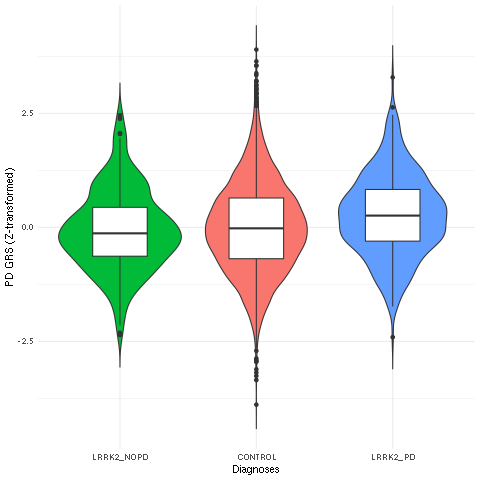

In \[133\]:

    %%R

    data %>%
      group_by(DIAGNOSIS) %>%
      summarise_at(vars(SCORE), list(mean = mean, sd = sd))

    # A tibble: 3 × 3
      DIAGNOSIS     mean      sd
      <chr>        <dbl>   <dbl>
    1 CONTROL    -0.0180 0.00436
    2 LRRK2_NOPD -0.0182 0.00386
    3 LRRK2_PD   -0.0168 0.00393

In \[113\]:

    %%R 

    kruskal.test(SCORE ~ DIAGNOSIS, data = data)

        Kruskal-Wallis rank sum test

    data:  SCORE by DIAGNOSIS
    Kruskal-Wallis chi-squared = 30.384, df = 2, p-value = 2.524e-07

In \[114\]:

    %%R

    pairwise.wilcox.test(data$SCORE, data$DIAGNOSIS,
                     p.adjust.method = "BH")

        Pairwise comparisons using Wilcoxon rank sum test with continuity correction 

    data:  data$SCORE and data$DIAGNOSIS 

               CONTROL LRRK2_NOPD
    LRRK2_NOPD 0.24    -         
    LRRK2_PD   5.1e-07 2.9e-06   

    P value adjustment method: BH